### GeoMx: Moffitt Hackathon 2021
#### Code SP
#### 9th Dec 2021


In [28]:
import numpy as np
import pandas as pd
import scipy.integrate
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
import time
import multiprocessing as mp
import os

from scipy.stats import zscore

from sklearn.manifold import TSNE
from sklearn.mixture import BayesianGaussianMixture


import scanpy as sc
import anndata


from scipy.spatial import distance

from sklearn.metrics.pairwise import euclidean_distances

In [10]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100)

In [2]:
colours_30 = ["firebrick","gold","royalblue","green","dimgray","orchid","darkviolet",
              "red", "orange", "limegreen", "blue", "purple", "seagreen","gold","darkolivegreen",
              "lightpink","thistle","mistyrose","saddlebrown","slategrey","powderblue",
            "palevioletred","mediumvioletred","yellowgreen","lemonchiffon","chocolate",
              "lightsalmon","lightcyan","lightblue", "darkorange","magenta","sienna","midnightblue","fuchsia","violet","tomato","aqua",
             "darkslategray","coral","lightcoral","sandybrown","indianred","olivedrab","darkgreen","blueviolet","forestgreen","darkred",
             "dimgray","teal","cadetblue"]

### Image of Lymph tissue

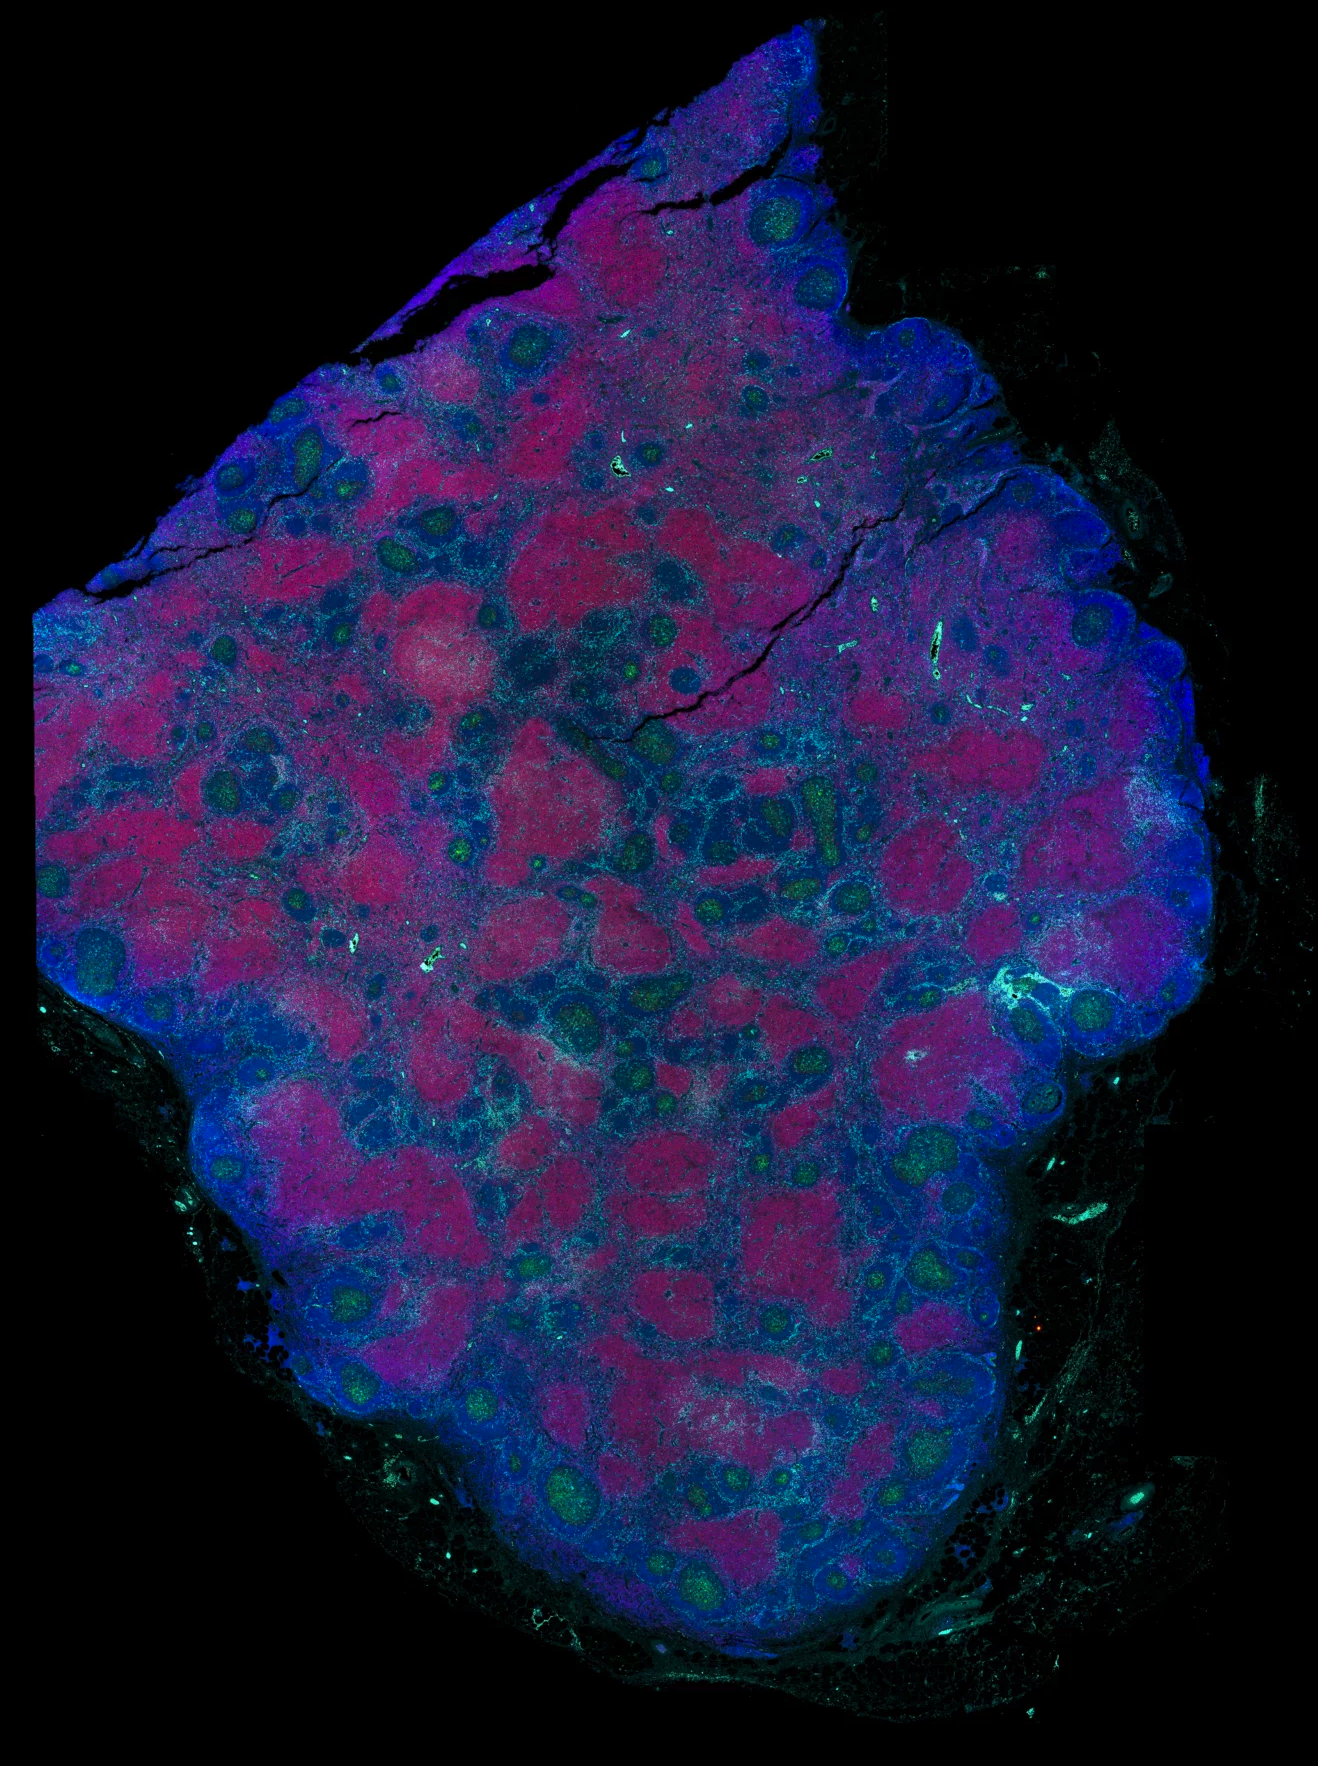

In [141]:
from IPython.display import Image
Image(filename= "/Users/4470526/Desktop/Lymph_image.png", width=400, height=400)
# https://www.nanostring.com/products/geomx-digital-spatial-profiler/spatial-organ-atlas/human-lymph-node/

### Extract data

In [31]:
file_10 =  np.array(pd.read_excel('/Users/4470526/Downloads/Projects/Moffitt_hackathon_2021/data/hu_lymph_node_count_results/Export4_NormalizationQ3.xlsx',sheet_name = 2, header=None,index_col=None))


In [32]:
roi_lymph = file_10[0,1:191]

In [33]:
genes_lymph = file_10[1:12481,0]


In [34]:
genes_lymph.shape

(12480,)

In [35]:
lymph_data = file_10[1:12481,1:191]

### Read the region/cell type mapping

In [37]:
file_100 =  np.array(pd.read_excel('/Users/4470526/Downloads/Projects/Moffitt_hackathon_2021/data/hu_lymph_node_count_results/Export4_NormalizationQ3.xlsx',sheet_name = 0, header=0,index_col=0))


In [38]:
## mapping the two sheets
roi_count = roi_lymph.shape[0]
roi_x_y = np.zeros([roi_count,2],dtype=float)
roi_type = []
for r in range(roi_count):
    for s in range(roi_count):
        if (roi_lymph[r] == file_100[s,3]):
            roi_x_y[r,0]=file_100[s,14]
            roi_x_y[r,1]=file_100[s,15]
            roi_type.append(file_100[s,32])
            break
            

In [42]:
roi_type=np.array(roi_type).flatten()

In [43]:
np.unique(roi_type, return_counts=True)

(array(['B cell zone', 'Germinal center', 'Medulla', 'T cell zone',
        'Trabecula'], dtype='<U15'), array([24, 77, 43, 24, 22]))

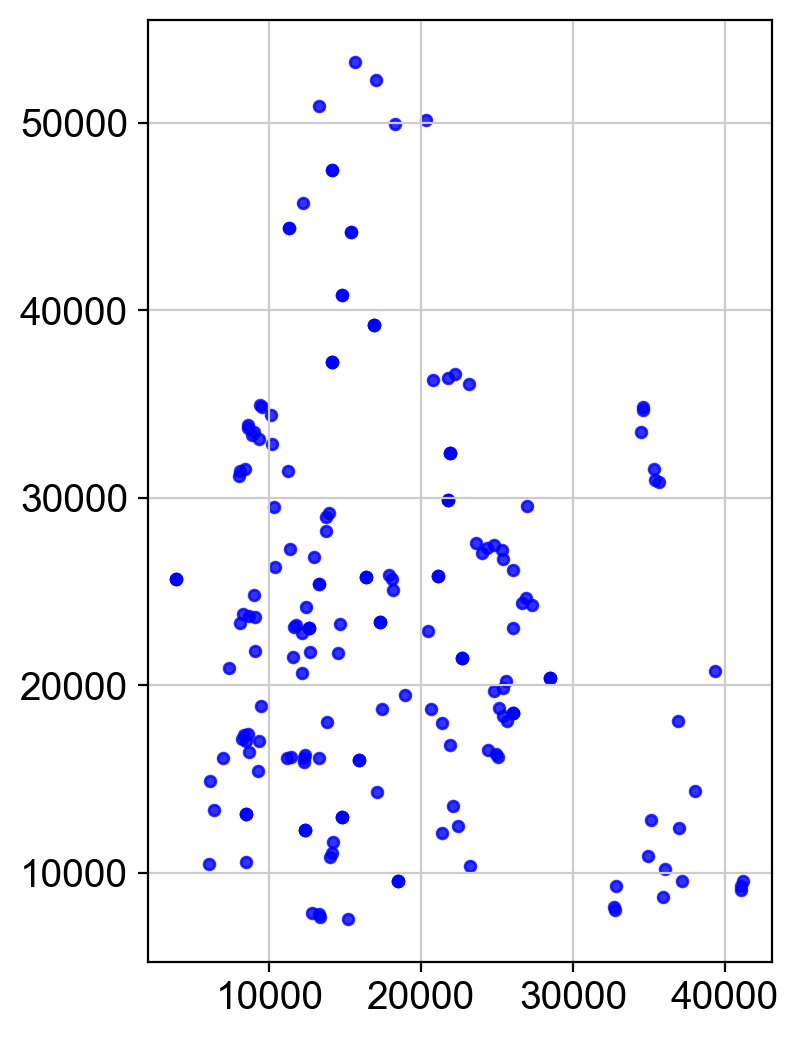

In [45]:
plt.figure(100, figsize=(4,6),frameon=False, dpi= 100)
plt.scatter(roi_x_y[:,0],roi_x_y[:,1],c= 'blue',s=15,alpha = 0.8, linewidths=1)

In [46]:
unique, counts = np.unique(roi_type, return_counts=True)
print('unique',str(unique))

unique ['B cell zone' 'Germinal center' 'Medulla' 'T cell zone' 'Trabecula']


Text(0.5, 1.0, 'image reconstruction using centroids')

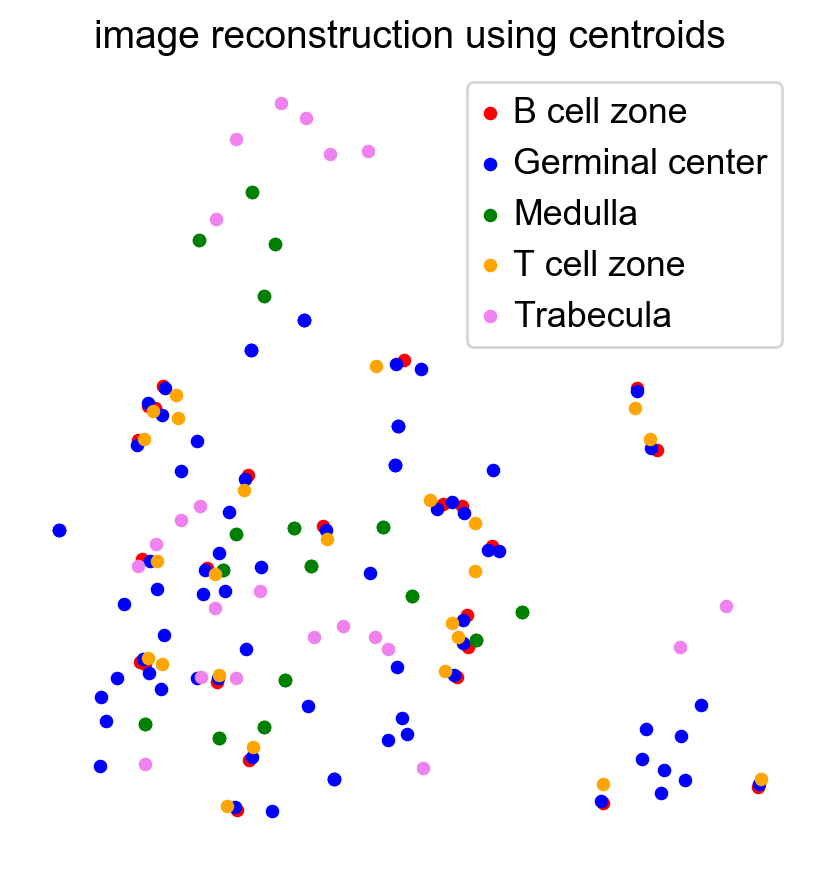

In [47]:
## plotting with annotation

colrs = ['red','blue','green','orange','violet']
target_ids = range(len(unique))
plt.figure(figsize=(5,5),frameon=False,dpi=100)
plt.axis('off')
#colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i,  label in zip(target_ids,  unique):
    #print(i)
    #print(label)
    c=colrs[i] #colours_30[i+1] #cm.colors[i]
    #print(c)
    plt.scatter(roi_x_y[ roi_type==(label), 0], roi_x_y[ roi_type==(label), 1], color=c,label=label,s=15,linewidths=1,alpha=1)
plt.legend()
plt.title('image reconstruction using centroids')

### Spatial matrix computation

Building the spat matrix


Text(0.5, 1.0, 'Euclidean distance')

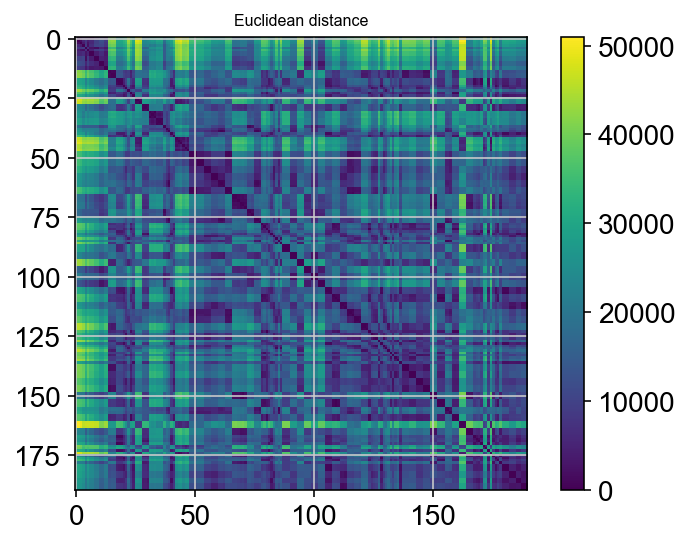

In [48]:
print('Building the spat matrix')

lymph_data_spat = np.copy(lymph_data)

ss= euclidean_distances(roi_x_y,roi_x_y)
plt.imshow(ss)
plt.colorbar()
plt.title('Euclidean distance', fontsize=8)

In [49]:
closest_rois = []

for ll in range(len(roi_x_y)):
    #print(ll)
    nn = np.argsort(ss[ll,:])[np.where((np.sort(ss[ll,:])[0:10]<10000)==True)]
    closest_rois.append(nn)
    #for nl in range(len(nn)):
    lymph_data_spat[ll,:] = np.mean(lymph_data[nn,:],axis=0) 
    #lymph_data_spat[ll,:] = np.mean(lymph_data[nn,:],axis=0) 

rs = lymph_data_spat.sum(axis=1,keepdims=True)
rm = np.where(rs==0)
lymph_data_spat = np.delete(lymph_data_spat,(rm), axis=0)
print(lymph_data_spat.shape)



(12480, 190)


In [ ]:
## save CM
df_lymph_data_spat = pd.DataFrame(lymph_data_spat)
df_lymph_data_spat.to_csv('lymph_data_spat.csv', header=None, index= None)

In [50]:
lymph_data_spat[0,0:10]

array([53.214991392548825, 66.46260528352087, 58.828387109062405,
       63.89648152740038, 53.34971288974513, 59.63671609224036,
       84.35832067433509, 83.16198182864738, 78.29332066949709,
       79.23080483762315], dtype=object)

### Data processing

In [5]:
lymph_data_spat = np.array(pd.read_csv('lymph_data_spat.csv', header=None,index_col=None))

In [6]:
lymph_data_spat.shape

(190, 12480)

In [8]:
adata_spat = sc.AnnData(lymph_data_spat)

normalizing counts per cell
    finished (0:00:00)


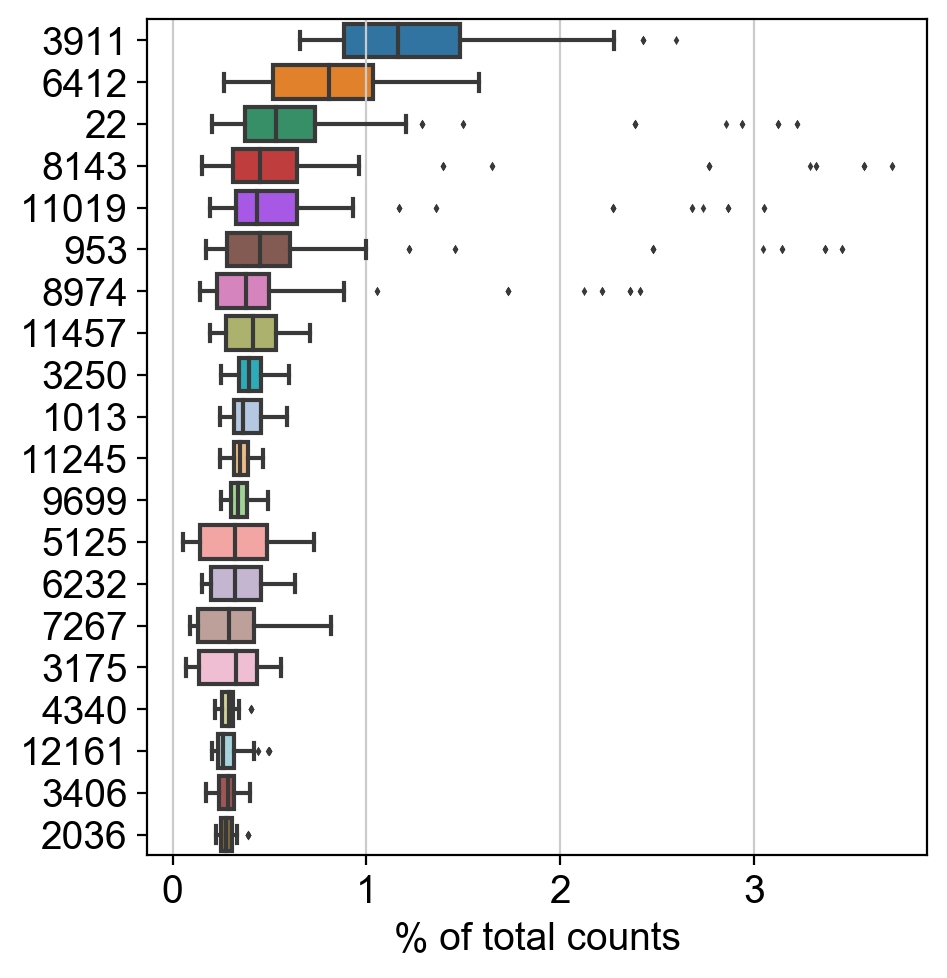

In [11]:
sc.pl.highest_expr_genes(adata_spat, n_top=20)

In [12]:
sc.pp.filter_cells(adata_spat, min_genes=50)
sc.pp.filter_genes(adata_spat, min_cells=3)

In [13]:
adata_spat

AnnData object with n_obs × n_vars = 190 × 12480
    obs: 'n_genes'
    var: 'n_cells'

In [14]:
sc.pp.highly_variable_genes(adata_spat, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=1000, flavor="cell_ranger", n_bins=20)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


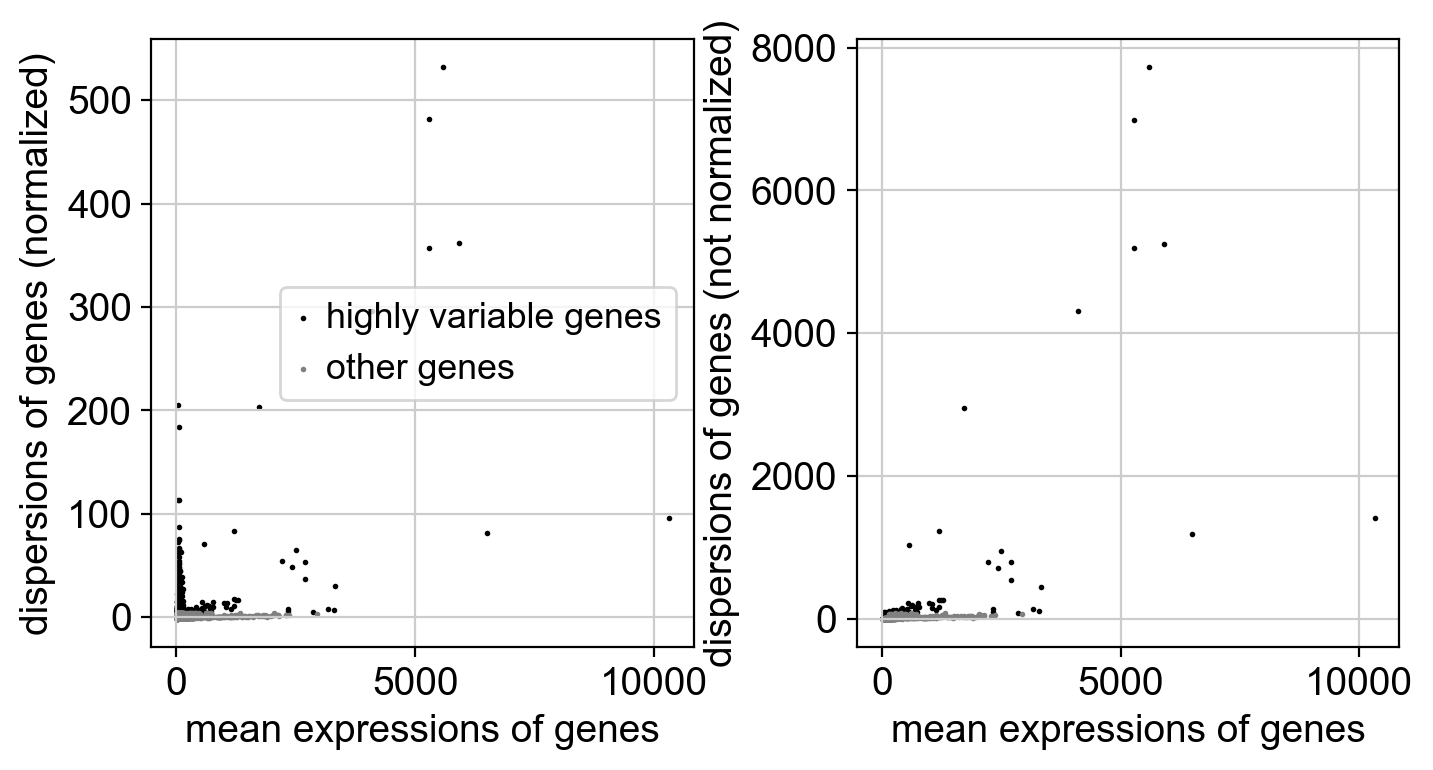

In [16]:
sc.pl.highly_variable_genes(adata_spat)

In [18]:
## leiden clustering
sc.pp.neighbors(adata_spat, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.leiden(adata_spat,resolution=0.5, random_state=42)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


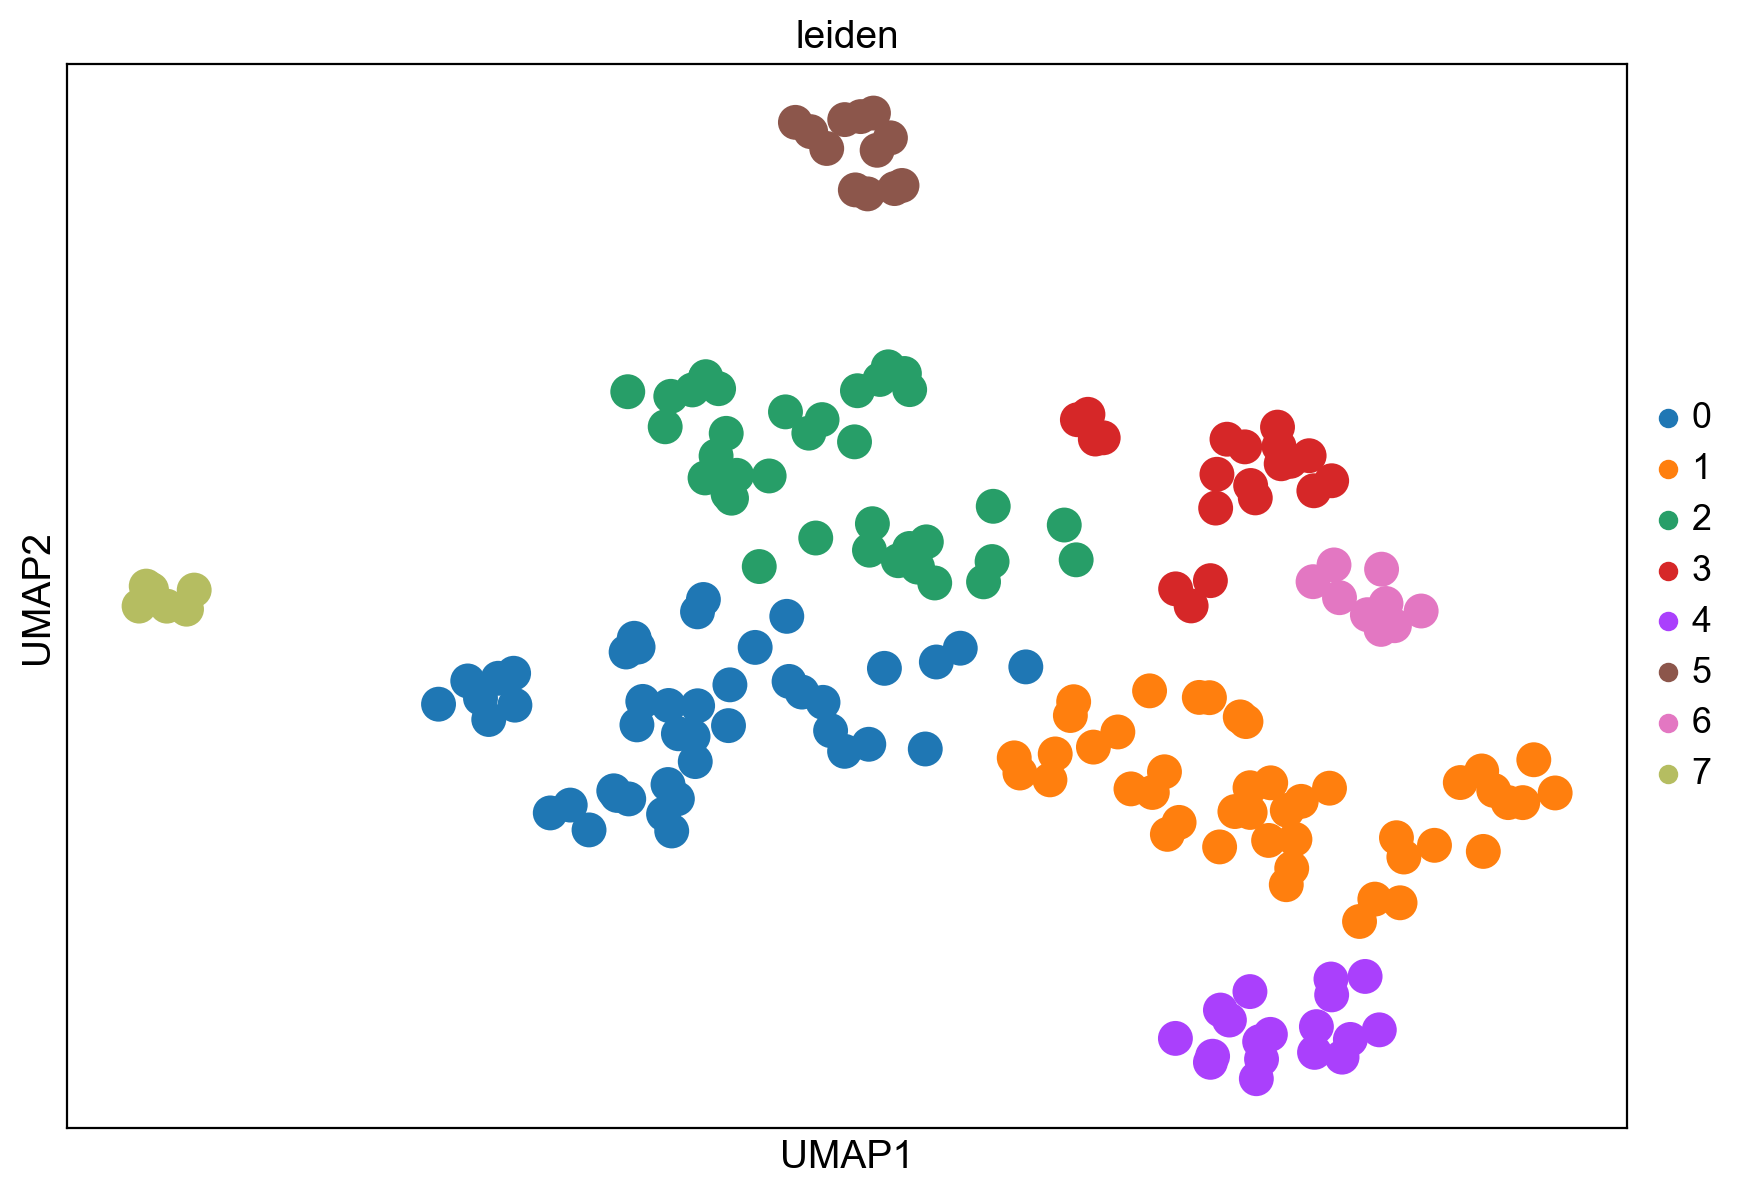

In [21]:
## UMAP
sc.tl.umap(adata_spat)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata_spat, color='leiden', ax=ax)#,legend_loc='on_data')

In [23]:
ids_counts = adata_spat.obs['leiden'].value_counts()
#ser_counts = ad_viz.obs['leiden'].value_counts()
print(ids_counts)

ids_c = adata_spat.obs['leiden']
print(ids_c)

1    44
0    44
2    37
3    20
4    18
5    12
6     9
7     6
Name: leiden, dtype: int64
0      5
1      5
2      5
3      5
4      5
      ..
185    1
186    1
187    6
188    6
189    6
Name: leiden, Length: 190, dtype: category
Categories (8, object): [0, 1, 2, 3, 4, 5, 6, 7]


In [25]:
ids_c_spat = np.copy(ids_c)

for i in range(len(ids_c)):
    ids_c_spat[i] = int(ids_c[i])

In [26]:
ids_c_spat

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 5, 5, 4, 4, 4, 1, 1, 1, 1, 4,
       0, 1, 1, 2, 2, 2, 2, 2, 1, 7, 7, 7, 7, 7, 7, 0, 0, 0, 1, 1, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 0, 0, 0, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 3, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2,
       2, 6, 6, 6, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 4, 4, 4, 4, 1, 1, 0, 0,
       1, 4, 1, 1, 1, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 0, 0, 0, 2, 2,
       2, 0, 0, 3, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 1, 1, 1, 6, 6, 6, 1, 1, 6, 6, 6], dtype=object)